<a href="https://colab.research.google.com/github/mubarok-ridho/MIRT-EduCDM-ASSISTments/blob/main/MIRT%2BPOMDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Ridho/EduCDM")

from EduCDM.MIRT.MIRT import MIRT

# Data Preparation

1. Data Preparation

Pertama, data hasil preprocessing dimuat dari file CSV. Dataset berasal dari ASSISTments Skill Builder yang sudah dibersihkan, lalu di-encode menggunakan latin1 untuk memastikan kompatibilitas karakter.

Langkah preprocessing:

-Drop missing values pada kolom user_id, problem_id, dan correct.

-Lakukan normalisasi (Z-score) pada fitur numerik jika ada (ms_first_response, attempt_count, hint_count).

-Encode answer_type jika tersedia.

-Pastikan label correct berupa binary 0/1.

Hasil akhirnya: dataset siap dipakai untuk pemetaan user–item.

In [ ]:
import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv",
    encoding="latin1"
)
df = df[["user_id", "problem_id", "correct"]]
print("Data shape:", df.shape)
print(df.head())

/tmp/ipython-input-4220339903.py:3: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Data shape: (340727, 3)
   user_id  problem_id  correct
0    64525       51424        1
1    64525       51435        1
2    70363       51444        0
3    70363       51395        1
4    70363       51481        0


Dataset & Dataloader

Agar model MIRT bisa dilatih, data diubah menjadi indeks numerik:

user_id → user_idx

problem_id → item_idx

In [ ]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
item_enc = LabelEncoder()

df["user_idx"] = user_enc.fit_transform(df["user_id"])
df["item_idx"] = item_enc.fit_transform(df["problem_id"])

num_users = df["user_idx"].nunique()
num_items = df["item_idx"].nunique()

print("num_users:", num_users, "num_items:", num_items)

num_users: 4213 num_items: 26642


In [ ]:
from sklearn.model_selection import GroupKFold

df_small = df[["user_idx", "item_idx", "correct"]]
folds = []
gkf = GroupKFold(n_splits=5)

for tr_idx, te_idx in gkf.split(df_small, groups=df_small["user_idx"]):
    train_df = df_small.iloc[tr_idx].reset_index(drop=True)
    test_df = df_small.iloc[te_idx].reset_index(drop=True)
    folds.append((train_df, test_df))

for i, (tr, te) in enumerate(folds, 1):
    print(f"Fold {i}: train={len(tr)}, test={len(te)}, "
          f"train_users={tr['user_idx'].nunique()}, test_users={te['user_idx'].nunique()}")

Fold 1: train=272581, test=68146, train_users=3370, test_users=843
Fold 2: train=272581, test=68146, train_users=3370, test_users=843
Fold 3: train=272582, test=68145, train_users=3371, test_users=842
Fold 4: train=272582, test=68145, train_users=3371, test_users=842
Fold 5: train=272582, test=68145, train_users=3370, test_users=843


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class InteractionDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df["user_idx"].values, dtype=torch.long)
        self.items = torch.tensor(df["item_idx"].values, dtype=torch.long)
        self.labels = torch.tensor(df["correct"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

def make_loaders(train_df, test_df, batch_size=512):
    train_loader = DataLoader(InteractionDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(InteractionDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Training Using Best Params

Model Training (MIRT)

Model MIRT (Multidimensional Item Response Theory) diambil dari mirt.py.
Struktur model:

θ_u: embedding user (kemampuan multidimensi).

a_i: embedding item discrimination.

b_i: embedding item difficulty.

Fungsinya:



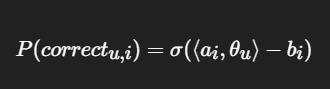

Hyperparameter yang digunakan:

latent_dim = 5
lr = 0.001
dropout = 0.3
batch = 512
epochs = 100

Training dilakukan per fold, model terbaik disimpan (.pth), dan hasil akhir AUC/Accuracy direkap.

In [ ]:
import os, json, numpy as np

LATENT_DIM = 5
A_RANGE = 1.0
BATCH = 512
EPOCHS = 30
LR = 0.001
DROPOUT = 0.3
MODEL_DIR = "/content/drive/MyDrive/Ridho/Models/MIRT_POMDP"
os.makedirs(MODEL_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

all_fold_results = []
for fold_id, (train_df, test_df) in enumerate(folds, 1):
    print(f"\n=== Fold {fold_id} ===")
    train_loader, test_loader = make_loaders(train_df, test_df, batch_size=BATCH)

    model = MIRT(user_num=num_users, item_num=num_items,
                 latent_dim=LATENT_DIM, a_range=A_RANGE, dropout=DROPOUT)

    save_path = os.path.join(MODEL_DIR, f"mirt_fold{fold_id}_best.pth")
    history = model.train(train_loader, test_loader,
                          epoch=EPOCHS, device=device, lr=LR,
                          save_path=save_path, return_history=True)

    auc_final, acc_final = model.eval(test_loader, device=device)
    print(f"[Fold {fold_id}] final AUC={auc_final:.4f}, Acc={acc_final:.4f}")
    all_fold_results.append((auc_final, acc_final))

aucs = [x[0] for x in all_fold_results]
accs = [x[1] for x in all_fold_results]
print("\n--- Hasil Cross-Validation (MIRT untuk POMDP) ---")
print(f"AUC rata-rata: {np.mean(aucs):.4f} ± {np.std(aucs, ddof=1):.4f}")
print(f"Akurasi rata-rata: {np.mean(accs):.4f} ± {np.std(accs, ddof=1):.4f}")

Using device: cpu

=== Fold 1 ===


Epoch 1: 100%|██████████| 533/533 [00:06<00:00, 82.41it/s]


[Epoch 1] Loss=0.667128 | AUC=0.688275, Acc=0.683342


Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 84.08it/s]


[Epoch 2] Loss=0.635976 | AUC=0.692213, Acc=0.680994


Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 67.68it/s]


[Epoch 3] Loss=0.621845 | AUC=0.694241, Acc=0.679424


Epoch 4: 100%|██████████| 533/533 [00:07<00:00, 71.89it/s]


[Epoch 4] Loss=0.612774 | AUC=0.695363, Acc=0.677677


Epoch 5: 100%|██████████| 533/533 [00:07<00:00, 69.12it/s]


[Epoch 5] Loss=0.605603 | AUC=0.696290, Acc=0.676900


Epoch 6: 100%|██████████| 533/533 [00:08<00:00, 63.93it/s]


[Epoch 6] Loss=0.598368 | AUC=0.696946, Acc=0.675638


Epoch 7: 100%|██████████| 533/533 [00:07<00:00, 74.21it/s]


[Epoch 7] Loss=0.592012 | AUC=0.697524, Acc=0.675344


Epoch 8: 100%|██████████| 533/533 [00:07<00:00, 68.58it/s]


[Epoch 8] Loss=0.585860 | AUC=0.697995, Acc=0.675168


Epoch 9: 100%|██████████| 533/533 [00:09<00:00, 53.75it/s]


[Epoch 9] Loss=0.580629 | AUC=0.698470, Acc=0.675139


Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 65.38it/s]


[Epoch 10] Loss=0.575649 | AUC=0.698865, Acc=0.675080


Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 73.39it/s]


[Epoch 11] Loss=0.570559 | AUC=0.699197, Acc=0.674992


Epoch 12: 100%|██████████| 533/533 [00:08<00:00, 63.14it/s]


[Epoch 12] Loss=0.566463 | AUC=0.699585, Acc=0.675139


Epoch 13: 100%|██████████| 533/533 [00:09<00:00, 56.58it/s]


[Epoch 13] Loss=0.562389 | AUC=0.699890, Acc=0.675153


Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 74.65it/s]


[Epoch 14] Loss=0.558019 | AUC=0.700194, Acc=0.675241


Epoch 15: 100%|██████████| 533/533 [00:07<00:00, 69.85it/s]


[Epoch 15] Loss=0.554426 | AUC=0.700445, Acc=0.675021


Epoch 16: 100%|██████████| 533/533 [00:09<00:00, 55.59it/s]


[Epoch 16] Loss=0.551314 | AUC=0.700710, Acc=0.675227


Epoch 17: 100%|██████████| 533/533 [00:07<00:00, 69.12it/s]


[Epoch 17] Loss=0.547828 | AUC=0.700908, Acc=0.675447


Epoch 18: 100%|██████████| 533/533 [00:07<00:00, 69.75it/s]


[Epoch 18] Loss=0.544945 | AUC=0.701088, Acc=0.675359


Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 65.03it/s]


[Epoch 19] Loss=0.542246 | AUC=0.701267, Acc=0.675667


Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 69.73it/s]


[Epoch 20] Loss=0.539650 | AUC=0.701438, Acc=0.675462


Epoch 21: 100%|██████████| 533/533 [00:07<00:00, 69.95it/s]


[Epoch 21] Loss=0.537203 | AUC=0.701594, Acc=0.675535


Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 62.62it/s]


[Epoch 22] Loss=0.535121 | AUC=0.701736, Acc=0.675506


Epoch 23: 100%|██████████| 533/533 [00:07<00:00, 68.35it/s]


[Epoch 23] Loss=0.532709 | AUC=0.701857, Acc=0.675623


Epoch 24: 100%|██████████| 533/533 [00:07<00:00, 70.13it/s]


[Epoch 24] Loss=0.530733 | AUC=0.701946, Acc=0.675814


Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 65.61it/s]


[Epoch 25] Loss=0.528503 | AUC=0.702027, Acc=0.675975


Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 70.53it/s]


[Epoch 26] Loss=0.526891 | AUC=0.702108, Acc=0.676269


Epoch 27: 100%|██████████| 533/533 [00:07<00:00, 68.96it/s]


[Epoch 27] Loss=0.525128 | AUC=0.702204, Acc=0.676283


Epoch 28: 100%|██████████| 533/533 [00:08<00:00, 62.50it/s]


[Epoch 28] Loss=0.523586 | AUC=0.702300, Acc=0.676768


Epoch 29: 100%|██████████| 533/533 [00:07<00:00, 70.10it/s]


[Epoch 29] Loss=0.521838 | AUC=0.702344, Acc=0.676650


Epoch 30: 100%|██████████| 533/533 [00:07<00:00, 72.33it/s]


[Epoch 30] Loss=0.520473 | AUC=0.702424, Acc=0.676885
[Fold 1] final AUC=0.7024, Acc=0.6769

=== Fold 2 ===


Epoch 1: 100%|██████████| 533/533 [00:07<00:00, 72.20it/s]


[Epoch 1] Loss=0.667394 | AUC=0.680600, Acc=0.688390


Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 76.89it/s]


[Epoch 2] Loss=0.637141 | AUC=0.684983, Acc=0.686365


Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 75.92it/s]


[Epoch 3] Loss=0.623165 | AUC=0.687028, Acc=0.684648


Epoch 4: 100%|██████████| 533/533 [00:08<00:00, 63.20it/s]


[Epoch 4] Loss=0.614050 | AUC=0.688400, Acc=0.683136


Epoch 5: 100%|██████████| 533/533 [00:07<00:00, 68.10it/s]


[Epoch 5] Loss=0.606440 | AUC=0.689271, Acc=0.682197


Epoch 6: 100%|██████████| 533/533 [00:14<00:00, 37.71it/s]


[Epoch 6] Loss=0.599206 | AUC=0.690095, Acc=0.681038


Epoch 7: 100%|██████████| 533/533 [00:07<00:00, 73.64it/s]


[Epoch 7] Loss=0.592930 | AUC=0.690712, Acc=0.680260


Epoch 8: 100%|██████████| 533/533 [00:08<00:00, 63.41it/s]


[Epoch 8] Loss=0.587182 | AUC=0.691220, Acc=0.679644


Epoch 9: 100%|██████████| 533/533 [00:08<00:00, 65.56it/s]


[Epoch 9] Loss=0.581332 | AUC=0.691693, Acc=0.679321


Epoch 10: 100%|██████████| 533/533 [00:07<00:00, 74.96it/s]


[Epoch 10] Loss=0.576678 | AUC=0.692075, Acc=0.678939


Epoch 11: 100%|██████████| 533/533 [00:08<00:00, 60.93it/s]


[Epoch 11] Loss=0.571716 | AUC=0.692460, Acc=0.678793


Epoch 12: 100%|██████████| 533/533 [00:09<00:00, 54.07it/s]


[Epoch 12] Loss=0.567160 | AUC=0.692887, Acc=0.679115


Epoch 13: 100%|██████████| 533/533 [00:07<00:00, 72.64it/s]


[Epoch 13] Loss=0.563336 | AUC=0.693230, Acc=0.679130


Epoch 14: 100%|██████████| 533/533 [00:08<00:00, 64.44it/s]


[Epoch 14] Loss=0.559084 | AUC=0.693540, Acc=0.679013


Epoch 15: 100%|██████████| 533/533 [00:08<00:00, 63.61it/s]


[Epoch 15] Loss=0.555833 | AUC=0.693818, Acc=0.678822


Epoch 16: 100%|██████████| 533/533 [00:07<00:00, 72.18it/s]


[Epoch 16] Loss=0.552183 | AUC=0.694098, Acc=0.678910


Epoch 17: 100%|██████████| 533/533 [00:08<00:00, 64.34it/s]


[Epoch 17] Loss=0.549345 | AUC=0.694358, Acc=0.679336


Epoch 18: 100%|██████████| 533/533 [00:08<00:00, 61.48it/s]


[Epoch 18] Loss=0.546312 | AUC=0.694598, Acc=0.679380


Epoch 19: 100%|██████████| 533/533 [00:07<00:00, 71.64it/s]


[Epoch 19] Loss=0.543307 | AUC=0.694831, Acc=0.679600


Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 67.42it/s]


[Epoch 20] Loss=0.540935 | AUC=0.695041, Acc=0.679878


Epoch 21: 100%|██████████| 533/533 [00:08<00:00, 64.99it/s]


[Epoch 21] Loss=0.538431 | AUC=0.695237, Acc=0.679923


Epoch 22: 100%|██████████| 533/533 [00:07<00:00, 74.04it/s]


[Epoch 22] Loss=0.536174 | AUC=0.695417, Acc=0.680304


Epoch 23: 100%|██████████| 533/533 [00:08<00:00, 66.46it/s]


[Epoch 23] Loss=0.533947 | AUC=0.695561, Acc=0.680319


Epoch 24: 100%|██████████| 533/533 [00:08<00:00, 62.88it/s]


[Epoch 24] Loss=0.531932 | AUC=0.695695, Acc=0.680583


Epoch 25: 100%|██████████| 533/533 [00:07<00:00, 73.66it/s]


[Epoch 25] Loss=0.529795 | AUC=0.695824, Acc=0.680686


Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 70.85it/s]


[Epoch 26] Loss=0.528041 | AUC=0.695948, Acc=0.680920


Epoch 27: 100%|██████████| 533/533 [00:08<00:00, 64.21it/s]


[Epoch 27] Loss=0.526219 | AUC=0.696056, Acc=0.681317


Epoch 28: 100%|██████████| 533/533 [00:07<00:00, 72.61it/s]


[Epoch 28] Loss=0.524718 | AUC=0.696152, Acc=0.681361


Epoch 29: 100%|██████████| 533/533 [00:08<00:00, 65.43it/s]


[Epoch 29] Loss=0.523270 | AUC=0.696236, Acc=0.681786


Epoch 30: 100%|██████████| 533/533 [00:08<00:00, 62.76it/s]


[Epoch 30] Loss=0.521414 | AUC=0.696336, Acc=0.681918
[Fold 2] final AUC=0.6963, Acc=0.6819

=== Fold 3 ===


Epoch 1: 100%|██████████| 533/533 [00:06<00:00, 81.50it/s]


[Epoch 1] Loss=0.667447 | AUC=0.678827, Acc=0.681297


Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 82.84it/s]


[Epoch 2] Loss=0.637332 | AUC=0.682925, Acc=0.678230


Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 67.59it/s]


[Epoch 3] Loss=0.623301 | AUC=0.684811, Acc=0.675809


Epoch 4: 100%|██████████| 533/533 [00:07<00:00, 72.28it/s]


[Epoch 4] Loss=0.613802 | AUC=0.685920, Acc=0.673916


Epoch 5: 100%|██████████| 533/533 [00:08<00:00, 65.83it/s]


[Epoch 5] Loss=0.606392 | AUC=0.686861, Acc=0.673079


Epoch 6: 100%|██████████| 533/533 [00:08<00:00, 62.30it/s]


[Epoch 6] Loss=0.599397 | AUC=0.687492, Acc=0.672859


Epoch 7: 100%|██████████| 533/533 [00:07<00:00, 68.84it/s]


[Epoch 7] Loss=0.592882 | AUC=0.688090, Acc=0.671744


Epoch 8: 100%|██████████| 533/533 [00:08<00:00, 60.00it/s]


[Epoch 8] Loss=0.586934 | AUC=0.688639, Acc=0.671186


Epoch 9: 100%|██████████| 533/533 [00:08<00:00, 62.58it/s]


[Epoch 9] Loss=0.581163 | AUC=0.689104, Acc=0.671230


Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 65.28it/s]


[Epoch 10] Loss=0.576192 | AUC=0.689570, Acc=0.671157


Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 73.63it/s]


[Epoch 11] Loss=0.571517 | AUC=0.689941, Acc=0.670688


Epoch 12: 100%|██████████| 533/533 [00:08<00:00, 61.93it/s]


[Epoch 12] Loss=0.567170 | AUC=0.690318, Acc=0.671054


Epoch 13: 100%|██████████| 533/533 [00:08<00:00, 66.34it/s]


[Epoch 13] Loss=0.562773 | AUC=0.690634, Acc=0.670761


Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 72.99it/s]


[Epoch 14] Loss=0.558706 | AUC=0.690933, Acc=0.670937


Epoch 15: 100%|██████████| 533/533 [00:08<00:00, 62.31it/s]


[Epoch 15] Loss=0.555205 | AUC=0.691194, Acc=0.671010


Epoch 16: 100%|██████████| 533/533 [00:08<00:00, 60.71it/s]


[Epoch 16] Loss=0.551888 | AUC=0.691466, Acc=0.671172


Epoch 17: 100%|██████████| 533/533 [00:07<00:00, 72.82it/s]


[Epoch 17] Loss=0.548806 | AUC=0.691712, Acc=0.671407


Epoch 18: 100%|██████████| 533/533 [00:08<00:00, 62.91it/s]


[Epoch 18] Loss=0.545876 | AUC=0.691954, Acc=0.671495


Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 63.48it/s]


[Epoch 19] Loss=0.542777 | AUC=0.692149, Acc=0.671583


Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 72.47it/s]


[Epoch 20] Loss=0.540114 | AUC=0.692331, Acc=0.671583


Epoch 21: 100%|██████████| 533/533 [00:08<00:00, 63.32it/s]


[Epoch 21] Loss=0.537738 | AUC=0.692494, Acc=0.671685


Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 62.40it/s]


[Epoch 22] Loss=0.535390 | AUC=0.692662, Acc=0.671847


Epoch 23: 100%|██████████| 533/533 [00:07<00:00, 71.04it/s]


[Epoch 23] Loss=0.533297 | AUC=0.692819, Acc=0.672492


Epoch 24: 100%|██████████| 533/533 [00:08<00:00, 62.45it/s]


[Epoch 24] Loss=0.531056 | AUC=0.692951, Acc=0.672507


Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 61.87it/s]


[Epoch 25] Loss=0.528841 | AUC=0.693116, Acc=0.672830


Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 72.76it/s]


[Epoch 26] Loss=0.527552 | AUC=0.693231, Acc=0.672654


Epoch 27: 100%|██████████| 533/533 [00:08<00:00, 64.10it/s]


[Epoch 27] Loss=0.525532 | AUC=0.693355, Acc=0.673065


Epoch 28: 100%|██████████| 533/533 [00:08<00:00, 63.76it/s]


[Epoch 28] Loss=0.523791 | AUC=0.693437, Acc=0.672991


Epoch 29: 100%|██████████| 533/533 [00:07<00:00, 73.59it/s]


[Epoch 29] Loss=0.522452 | AUC=0.693508, Acc=0.673123


Epoch 30: 100%|██████████| 533/533 [00:08<00:00, 65.52it/s]


[Epoch 30] Loss=0.520967 | AUC=0.693590, Acc=0.673578
[Fold 3] final AUC=0.6936, Acc=0.6736

=== Fold 4 ===


Epoch 1: 100%|██████████| 533/533 [00:07<00:00, 72.95it/s]


[Epoch 1] Loss=0.667477 | AUC=0.691404, Acc=0.684320


Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 87.04it/s]


[Epoch 2] Loss=0.636987 | AUC=0.695602, Acc=0.683161


Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 67.79it/s]


[Epoch 3] Loss=0.623322 | AUC=0.697376, Acc=0.681356


Epoch 4: 100%|██████████| 533/533 [00:08<00:00, 62.93it/s]


[Epoch 4] Loss=0.614498 | AUC=0.698517, Acc=0.680035


Epoch 5: 100%|██████████| 533/533 [00:08<00:00, 66.24it/s]


[Epoch 5] Loss=0.606480 | AUC=0.699235, Acc=0.678861


Epoch 6: 100%|██████████| 533/533 [00:08<00:00, 61.86it/s]


[Epoch 6] Loss=0.599615 | AUC=0.699837, Acc=0.678010


Epoch 7: 100%|██████████| 533/533 [00:08<00:00, 65.44it/s]


[Epoch 7] Loss=0.593494 | AUC=0.700375, Acc=0.677291


Epoch 8: 100%|██████████| 533/533 [00:07<00:00, 71.65it/s]


[Epoch 8] Loss=0.587724 | AUC=0.700856, Acc=0.677100


Epoch 9: 100%|██████████| 533/533 [00:08<00:00, 63.33it/s]


[Epoch 9] Loss=0.581846 | AUC=0.701347, Acc=0.677130


Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 64.57it/s]


[Epoch 10] Loss=0.576757 | AUC=0.701737, Acc=0.676851


Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 73.60it/s]


[Epoch 11] Loss=0.572264 | AUC=0.702117, Acc=0.676910


Epoch 12: 100%|██████████| 533/533 [00:08<00:00, 64.04it/s]


[Epoch 12] Loss=0.567912 | AUC=0.702431, Acc=0.676601


Epoch 13: 100%|██████████| 533/533 [00:07<00:00, 66.81it/s]


[Epoch 13] Loss=0.563631 | AUC=0.702735, Acc=0.676601


Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 70.46it/s]


[Epoch 14] Loss=0.559565 | AUC=0.703042, Acc=0.676748


Epoch 15: 100%|██████████| 533/533 [00:08<00:00, 61.29it/s]


[Epoch 15] Loss=0.556124 | AUC=0.703375, Acc=0.676792


Epoch 16: 100%|██████████| 533/533 [00:08<00:00, 62.45it/s]


[Epoch 16] Loss=0.552869 | AUC=0.703613, Acc=0.676895


Epoch 17: 100%|██████████| 533/533 [00:07<00:00, 70.51it/s]


[Epoch 17] Loss=0.549668 | AUC=0.703822, Acc=0.676631


Epoch 18: 100%|██████████| 533/533 [00:08<00:00, 62.67it/s]


[Epoch 18] Loss=0.546680 | AUC=0.704056, Acc=0.676880


Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 62.37it/s]


[Epoch 19] Loss=0.543978 | AUC=0.704263, Acc=0.677144


Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 72.95it/s]


[Epoch 20] Loss=0.541429 | AUC=0.704441, Acc=0.677012


Epoch 21: 100%|██████████| 533/533 [00:08<00:00, 64.82it/s]


[Epoch 21] Loss=0.538668 | AUC=0.704646, Acc=0.677100


Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 63.62it/s]


[Epoch 22] Loss=0.536799 | AUC=0.704807, Acc=0.677306


Epoch 23: 100%|██████████| 533/533 [00:07<00:00, 68.72it/s]


[Epoch 23] Loss=0.534445 | AUC=0.704944, Acc=0.677394


Epoch 24: 100%|██████████| 533/533 [00:08<00:00, 61.03it/s]


[Epoch 24] Loss=0.532425 | AUC=0.705068, Acc=0.677379


Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 62.67it/s]


[Epoch 25] Loss=0.530261 | AUC=0.705218, Acc=0.677526


Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 73.38it/s]


[Epoch 26] Loss=0.528605 | AUC=0.705298, Acc=0.677394


Epoch 27: 100%|██████████| 533/533 [00:08<00:00, 61.21it/s]


[Epoch 27] Loss=0.526968 | AUC=0.705410, Acc=0.677702


Epoch 28: 100%|██████████| 533/533 [00:08<00:00, 61.60it/s]


[Epoch 28] Loss=0.525342 | AUC=0.705497, Acc=0.677819


Epoch 29: 100%|██████████| 533/533 [00:07<00:00, 73.29it/s]


[Epoch 29] Loss=0.523598 | AUC=0.705565, Acc=0.677878


Epoch 30: 100%|██████████| 533/533 [00:08<00:00, 65.68it/s]


[Epoch 30] Loss=0.522000 | AUC=0.705659, Acc=0.678098
[Fold 4] final AUC=0.7057, Acc=0.6781

=== Fold 5 ===


Epoch 1: 100%|██████████| 533/533 [00:08<00:00, 62.55it/s]


[Epoch 1] Loss=0.667437 | AUC=0.685789, Acc=0.685612


Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 87.33it/s]


[Epoch 2] Loss=0.637342 | AUC=0.688935, Acc=0.682163


Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 71.12it/s]


[Epoch 3] Loss=0.623940 | AUC=0.690402, Acc=0.679125


Epoch 4: 100%|██████████| 533/533 [00:08<00:00, 60.97it/s]


[Epoch 4] Loss=0.614719 | AUC=0.691281, Acc=0.676381


Epoch 5: 100%|██████████| 533/533 [00:07<00:00, 72.23it/s]


[Epoch 5] Loss=0.606790 | AUC=0.691884, Acc=0.674297


Epoch 6: 100%|██████████| 533/533 [00:07<00:00, 67.22it/s]


[Epoch 6] Loss=0.599899 | AUC=0.692457, Acc=0.673549


Epoch 7: 100%|██████████| 533/533 [00:08<00:00, 63.47it/s]


[Epoch 7] Loss=0.593463 | AUC=0.692935, Acc=0.672977


Epoch 8: 100%|██████████| 533/533 [00:07<00:00, 71.80it/s]


[Epoch 8] Loss=0.587557 | AUC=0.693410, Acc=0.672669


Epoch 9: 100%|██████████| 533/533 [00:07<00:00, 67.66it/s]


[Epoch 9] Loss=0.582257 | AUC=0.693852, Acc=0.672184


Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 61.36it/s]


[Epoch 10] Loss=0.577249 | AUC=0.694250, Acc=0.671627


Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 68.36it/s]


[Epoch 11] Loss=0.571993 | AUC=0.694648, Acc=0.671715


Epoch 12: 100%|██████████| 533/533 [00:07<00:00, 69.02it/s]


[Epoch 12] Loss=0.567856 | AUC=0.695001, Acc=0.671715


Epoch 13: 100%|██████████| 533/533 [00:08<00:00, 64.95it/s]


[Epoch 13] Loss=0.563725 | AUC=0.695282, Acc=0.671436


Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 68.61it/s]


[Epoch 14] Loss=0.560048 | AUC=0.695616, Acc=0.671524


Epoch 15: 100%|██████████| 533/533 [00:07<00:00, 67.78it/s]


[Epoch 15] Loss=0.556331 | AUC=0.695954, Acc=0.671685


Epoch 16: 100%|██████████| 533/533 [00:08<00:00, 62.65it/s]


[Epoch 16] Loss=0.553013 | AUC=0.696240, Acc=0.671759


Epoch 17: 100%|██████████| 533/533 [00:08<00:00, 64.99it/s]


[Epoch 17] Loss=0.549921 | AUC=0.696486, Acc=0.671876


Epoch 18: 100%|██████████| 533/533 [00:07<00:00, 69.90it/s]


[Epoch 18] Loss=0.546762 | AUC=0.696723, Acc=0.672023


Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 63.52it/s]


[Epoch 19] Loss=0.544021 | AUC=0.696965, Acc=0.672170


Epoch 20: 100%|██████████| 533/533 [00:08<00:00, 65.20it/s]


[Epoch 20] Loss=0.541333 | AUC=0.697131, Acc=0.672214


Epoch 21: 100%|██████████| 533/533 [00:07<00:00, 71.45it/s]


[Epoch 21] Loss=0.539245 | AUC=0.697297, Acc=0.672155


Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 61.59it/s]


[Epoch 22] Loss=0.536363 | AUC=0.697490, Acc=0.672625


Epoch 23: 100%|██████████| 533/533 [00:08<00:00, 64.88it/s]


[Epoch 23] Loss=0.534392 | AUC=0.697614, Acc=0.672507


Epoch 24: 100%|██████████| 533/533 [00:07<00:00, 74.31it/s]


[Epoch 24] Loss=0.532381 | AUC=0.697770, Acc=0.672537


Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 63.09it/s]


[Epoch 25] Loss=0.530267 | AUC=0.697922, Acc=0.672918


Epoch 26: 100%|██████████| 533/533 [00:08<00:00, 64.32it/s]


[Epoch 26] Loss=0.528674 | AUC=0.698020, Acc=0.672859


Epoch 27: 100%|██████████| 533/533 [00:07<00:00, 70.00it/s]


[Epoch 27] Loss=0.527006 | AUC=0.698143, Acc=0.673006


Epoch 28: 100%|██████████| 533/533 [00:10<00:00, 52.62it/s]


[Epoch 28] Loss=0.525361 | AUC=0.698256, Acc=0.673138


Epoch 29: 100%|██████████| 533/533 [00:08<00:00, 62.33it/s]


[Epoch 29] Loss=0.523704 | AUC=0.698341, Acc=0.673476


Epoch 30: 100%|██████████| 533/533 [00:07<00:00, 71.90it/s]


[Epoch 30] Loss=0.522352 | AUC=0.698414, Acc=0.673446
[Fold 5] final AUC=0.6984, Acc=0.6734

--- Hasil Cross-Validation (MIRT untuk POMDP) ---
AUC rata-rata: 0.6993 ± 0.0048
Akurasi rata-rata: 0.6768 ± 0.0035


Ekstraksi Parameter MIRT

Setelah training, model terbaik diambil lalu parameternya diekstrak untuk POMDP:

- theta_all: embedding kemampuan user
- a: discrimination item
- b: difficulty item

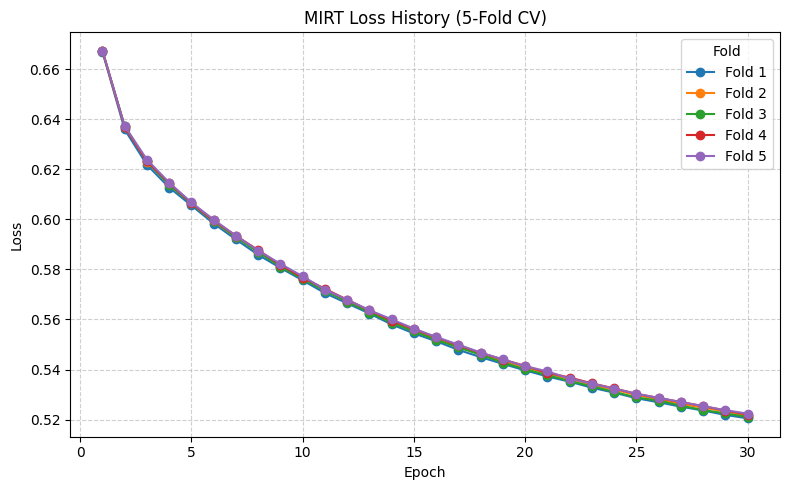

In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd

# ===========================================
# MASUKKAN LOG TRAINING MIRT (hasil print lengkap)
# ===========================================
log_text = """
[Using device: cpu

=== Fold 1 ===
Epoch 1: 100%|██████████| 533/533 [00:06<00:00, 82.41it/s]
[Epoch 1] Loss=0.667128 | AUC=0.688275, Acc=0.683342
Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 84.08it/s]
[Epoch 2] Loss=0.635976 | AUC=0.692213, Acc=0.680994
Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 67.68it/s]
[Epoch 3] Loss=0.621845 | AUC=0.694241, Acc=0.679424
Epoch 4: 100%|██████████| 533/533 [00:07<00:00, 71.89it/s]
[Epoch 4] Loss=0.612774 | AUC=0.695363, Acc=0.677677
Epoch 5: 100%|██████████| 533/533 [00:07<00:00, 69.12it/s]
[Epoch 5] Loss=0.605603 | AUC=0.696290, Acc=0.676900
Epoch 6: 100%|██████████| 533/533 [00:08<00:00, 63.93it/s]
[Epoch 6] Loss=0.598368 | AUC=0.696946, Acc=0.675638
Epoch 7: 100%|██████████| 533/533 [00:07<00:00, 74.21it/s]
[Epoch 7] Loss=0.592012 | AUC=0.697524, Acc=0.675344
Epoch 8: 100%|██████████| 533/533 [00:07<00:00, 68.58it/s]
[Epoch 8] Loss=0.585860 | AUC=0.697995, Acc=0.675168
Epoch 9: 100%|██████████| 533/533 [00:09<00:00, 53.75it/s]
[Epoch 9] Loss=0.580629 | AUC=0.698470, Acc=0.675139
Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 65.38it/s]
[Epoch 10] Loss=0.575649 | AUC=0.698865, Acc=0.675080
Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 73.39it/s]
[Epoch 11] Loss=0.570559 | AUC=0.699197, Acc=0.674992
Epoch 12: 100%|██████████| 533/533 [00:08<00:00, 63.14it/s]
[Epoch 12] Loss=0.566463 | AUC=0.699585, Acc=0.675139
Epoch 13: 100%|██████████| 533/533 [00:09<00:00, 56.58it/s]
[Epoch 13] Loss=0.562389 | AUC=0.699890, Acc=0.675153
Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 74.65it/s]
[Epoch 14] Loss=0.558019 | AUC=0.700194, Acc=0.675241
Epoch 15: 100%|██████████| 533/533 [00:07<00:00, 69.85it/s]
[Epoch 15] Loss=0.554426 | AUC=0.700445, Acc=0.675021
Epoch 16: 100%|██████████| 533/533 [00:09<00:00, 55.59it/s]
[Epoch 16] Loss=0.551314 | AUC=0.700710, Acc=0.675227
Epoch 17: 100%|██████████| 533/533 [00:07<00:00, 69.12it/s]
[Epoch 17] Loss=0.547828 | AUC=0.700908, Acc=0.675447
Epoch 18: 100%|██████████| 533/533 [00:07<00:00, 69.75it/s]
[Epoch 18] Loss=0.544945 | AUC=0.701088, Acc=0.675359
Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 65.03it/s]
[Epoch 19] Loss=0.542246 | AUC=0.701267, Acc=0.675667
Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 69.73it/s]
[Epoch 20] Loss=0.539650 | AUC=0.701438, Acc=0.675462
Epoch 21: 100%|██████████| 533/533 [00:07<00:00, 69.95it/s]
[Epoch 21] Loss=0.537203 | AUC=0.701594, Acc=0.675535
Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 62.62it/s]
[Epoch 22] Loss=0.535121 | AUC=0.701736, Acc=0.675506
Epoch 23: 100%|██████████| 533/533 [00:07<00:00, 68.35it/s]
[Epoch 23] Loss=0.532709 | AUC=0.701857, Acc=0.675623
Epoch 24: 100%|██████████| 533/533 [00:07<00:00, 70.13it/s]
[Epoch 24] Loss=0.530733 | AUC=0.701946, Acc=0.675814
Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 65.61it/s]
[Epoch 25] Loss=0.528503 | AUC=0.702027, Acc=0.675975
Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 70.53it/s]
[Epoch 26] Loss=0.526891 | AUC=0.702108, Acc=0.676269
Epoch 27: 100%|██████████| 533/533 [00:07<00:00, 68.96it/s]
[Epoch 27] Loss=0.525128 | AUC=0.702204, Acc=0.676283
Epoch 28: 100%|██████████| 533/533 [00:08<00:00, 62.50it/s]
[Epoch 28] Loss=0.523586 | AUC=0.702300, Acc=0.676768
Epoch 29: 100%|██████████| 533/533 [00:07<00:00, 70.10it/s]
[Epoch 29] Loss=0.521838 | AUC=0.702344, Acc=0.676650
Epoch 30: 100%|██████████| 533/533 [00:07<00:00, 72.33it/s]
[Epoch 30] Loss=0.520473 | AUC=0.702424, Acc=0.676885
[Fold 1] final AUC=0.7024, Acc=0.6769

=== Fold 2 ===
Epoch 1: 100%|██████████| 533/533 [00:07<00:00, 72.20it/s]
[Epoch 1] Loss=0.667394 | AUC=0.680600, Acc=0.688390
Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 76.89it/s]
[Epoch 2] Loss=0.637141 | AUC=0.684983, Acc=0.686365
Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 75.92it/s]
[Epoch 3] Loss=0.623165 | AUC=0.687028, Acc=0.684648
Epoch 4: 100%|██████████| 533/533 [00:08<00:00, 63.20it/s]
[Epoch 4] Loss=0.614050 | AUC=0.688400, Acc=0.683136
Epoch 5: 100%|██████████| 533/533 [00:07<00:00, 68.10it/s]
[Epoch 5] Loss=0.606440 | AUC=0.689271, Acc=0.682197
Epoch 6: 100%|██████████| 533/533 [00:14<00:00, 37.71it/s]
[Epoch 6] Loss=0.599206 | AUC=0.690095, Acc=0.681038
Epoch 7: 100%|██████████| 533/533 [00:07<00:00, 73.64it/s]
[Epoch 7] Loss=0.592930 | AUC=0.690712, Acc=0.680260
Epoch 8: 100%|██████████| 533/533 [00:08<00:00, 63.41it/s]
[Epoch 8] Loss=0.587182 | AUC=0.691220, Acc=0.679644
Epoch 9: 100%|██████████| 533/533 [00:08<00:00, 65.56it/s]
[Epoch 9] Loss=0.581332 | AUC=0.691693, Acc=0.679321
Epoch 10: 100%|██████████| 533/533 [00:07<00:00, 74.96it/s]
[Epoch 10] Loss=0.576678 | AUC=0.692075, Acc=0.678939
Epoch 11: 100%|██████████| 533/533 [00:08<00:00, 60.93it/s]
[Epoch 11] Loss=0.571716 | AUC=0.692460, Acc=0.678793
Epoch 12: 100%|██████████| 533/533 [00:09<00:00, 54.07it/s]
[Epoch 12] Loss=0.567160 | AUC=0.692887, Acc=0.679115
Epoch 13: 100%|██████████| 533/533 [00:07<00:00, 72.64it/s]
[Epoch 13] Loss=0.563336 | AUC=0.693230, Acc=0.679130
Epoch 14: 100%|██████████| 533/533 [00:08<00:00, 64.44it/s]
[Epoch 14] Loss=0.559084 | AUC=0.693540, Acc=0.679013
Epoch 15: 100%|██████████| 533/533 [00:08<00:00, 63.61it/s]
[Epoch 15] Loss=0.555833 | AUC=0.693818, Acc=0.678822
Epoch 16: 100%|██████████| 533/533 [00:07<00:00, 72.18it/s]
[Epoch 16] Loss=0.552183 | AUC=0.694098, Acc=0.678910
Epoch 17: 100%|██████████| 533/533 [00:08<00:00, 64.34it/s]
[Epoch 17] Loss=0.549345 | AUC=0.694358, Acc=0.679336
Epoch 18: 100%|██████████| 533/533 [00:08<00:00, 61.48it/s]
[Epoch 18] Loss=0.546312 | AUC=0.694598, Acc=0.679380
Epoch 19: 100%|██████████| 533/533 [00:07<00:00, 71.64it/s]
[Epoch 19] Loss=0.543307 | AUC=0.694831, Acc=0.679600
Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 67.42it/s]
[Epoch 20] Loss=0.540935 | AUC=0.695041, Acc=0.679878
Epoch 21: 100%|██████████| 533/533 [00:08<00:00, 64.99it/s]
[Epoch 21] Loss=0.538431 | AUC=0.695237, Acc=0.679923
Epoch 22: 100%|██████████| 533/533 [00:07<00:00, 74.04it/s]
[Epoch 22] Loss=0.536174 | AUC=0.695417, Acc=0.680304
Epoch 23: 100%|██████████| 533/533 [00:08<00:00, 66.46it/s]
[Epoch 23] Loss=0.533947 | AUC=0.695561, Acc=0.680319
Epoch 24: 100%|██████████| 533/533 [00:08<00:00, 62.88it/s]
[Epoch 24] Loss=0.531932 | AUC=0.695695, Acc=0.680583
Epoch 25: 100%|██████████| 533/533 [00:07<00:00, 73.66it/s]
[Epoch 25] Loss=0.529795 | AUC=0.695824, Acc=0.680686
Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 70.85it/s]
[Epoch 26] Loss=0.528041 | AUC=0.695948, Acc=0.680920
Epoch 27: 100%|██████████| 533/533 [00:08<00:00, 64.21it/s]
[Epoch 27] Loss=0.526219 | AUC=0.696056, Acc=0.681317
Epoch 28: 100%|██████████| 533/533 [00:07<00:00, 72.61it/s]
[Epoch 28] Loss=0.524718 | AUC=0.696152, Acc=0.681361
Epoch 29: 100%|██████████| 533/533 [00:08<00:00, 65.43it/s]
[Epoch 29] Loss=0.523270 | AUC=0.696236, Acc=0.681786
Epoch 30: 100%|██████████| 533/533 [00:08<00:00, 62.76it/s]
[Epoch 30] Loss=0.521414 | AUC=0.696336, Acc=0.681918
[Fold 2] final AUC=0.6963, Acc=0.6819

=== Fold 3 ===
Epoch 1: 100%|██████████| 533/533 [00:06<00:00, 81.50it/s]
[Epoch 1] Loss=0.667447 | AUC=0.678827, Acc=0.681297
Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 82.84it/s]
[Epoch 2] Loss=0.637332 | AUC=0.682925, Acc=0.678230
Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 67.59it/s]
[Epoch 3] Loss=0.623301 | AUC=0.684811, Acc=0.675809
Epoch 4: 100%|██████████| 533/533 [00:07<00:00, 72.28it/s]
[Epoch 4] Loss=0.613802 | AUC=0.685920, Acc=0.673916
Epoch 5: 100%|██████████| 533/533 [00:08<00:00, 65.83it/s]
[Epoch 5] Loss=0.606392 | AUC=0.686861, Acc=0.673079
Epoch 6: 100%|██████████| 533/533 [00:08<00:00, 62.30it/s]
[Epoch 6] Loss=0.599397 | AUC=0.687492, Acc=0.672859
Epoch 7: 100%|██████████| 533/533 [00:07<00:00, 68.84it/s]
[Epoch 7] Loss=0.592882 | AUC=0.688090, Acc=0.671744
Epoch 8: 100%|██████████| 533/533 [00:08<00:00, 60.00it/s]
[Epoch 8] Loss=0.586934 | AUC=0.688639, Acc=0.671186
Epoch 9: 100%|██████████| 533/533 [00:08<00:00, 62.58it/s]
[Epoch 9] Loss=0.581163 | AUC=0.689104, Acc=0.671230
Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 65.28it/s]
[Epoch 10] Loss=0.576192 | AUC=0.689570, Acc=0.671157
Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 73.63it/s]
[Epoch 11] Loss=0.571517 | AUC=0.689941, Acc=0.670688
Epoch 12: 100%|██████████| 533/533 [00:08<00:00, 61.93it/s]
[Epoch 12] Loss=0.567170 | AUC=0.690318, Acc=0.671054
Epoch 13: 100%|██████████| 533/533 [00:08<00:00, 66.34it/s]
[Epoch 13] Loss=0.562773 | AUC=0.690634, Acc=0.670761
Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 72.99it/s]
[Epoch 14] Loss=0.558706 | AUC=0.690933, Acc=0.670937
Epoch 15: 100%|██████████| 533/533 [00:08<00:00, 62.31it/s]
[Epoch 15] Loss=0.555205 | AUC=0.691194, Acc=0.671010
Epoch 16: 100%|██████████| 533/533 [00:08<00:00, 60.71it/s]
[Epoch 16] Loss=0.551888 | AUC=0.691466, Acc=0.671172
Epoch 17: 100%|██████████| 533/533 [00:07<00:00, 72.82it/s]
[Epoch 17] Loss=0.548806 | AUC=0.691712, Acc=0.671407
Epoch 18: 100%|██████████| 533/533 [00:08<00:00, 62.91it/s]
[Epoch 18] Loss=0.545876 | AUC=0.691954, Acc=0.671495
Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 63.48it/s]
[Epoch 19] Loss=0.542777 | AUC=0.692149, Acc=0.671583
Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 72.47it/s]
[Epoch 20] Loss=0.540114 | AUC=0.692331, Acc=0.671583
Epoch 21: 100%|██████████| 533/533 [00:08<00:00, 63.32it/s]
[Epoch 21] Loss=0.537738 | AUC=0.692494, Acc=0.671685
Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 62.40it/s]
[Epoch 22] Loss=0.535390 | AUC=0.692662, Acc=0.671847
Epoch 23: 100%|██████████| 533/533 [00:07<00:00, 71.04it/s]
[Epoch 23] Loss=0.533297 | AUC=0.692819, Acc=0.672492
Epoch 24: 100%|██████████| 533/533 [00:08<00:00, 62.45it/s]
[Epoch 24] Loss=0.531056 | AUC=0.692951, Acc=0.672507
Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 61.87it/s]
[Epoch 25] Loss=0.528841 | AUC=0.693116, Acc=0.672830
Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 72.76it/s]
[Epoch 26] Loss=0.527552 | AUC=0.693231, Acc=0.672654
Epoch 27: 100%|██████████| 533/533 [00:08<00:00, 64.10it/s]
[Epoch 27] Loss=0.525532 | AUC=0.693355, Acc=0.673065
Epoch 28: 100%|██████████| 533/533 [00:08<00:00, 63.76it/s]
[Epoch 28] Loss=0.523791 | AUC=0.693437, Acc=0.672991
Epoch 29: 100%|██████████| 533/533 [00:07<00:00, 73.59it/s]
[Epoch 29] Loss=0.522452 | AUC=0.693508, Acc=0.673123
Epoch 30: 100%|██████████| 533/533 [00:08<00:00, 65.52it/s]
[Epoch 30] Loss=0.520967 | AUC=0.693590, Acc=0.673578
[Fold 3] final AUC=0.6936, Acc=0.6736

=== Fold 4 ===
Epoch 1: 100%|██████████| 533/533 [00:07<00:00, 72.95it/s]
[Epoch 1] Loss=0.667477 | AUC=0.691404, Acc=0.684320
Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 87.04it/s]
[Epoch 2] Loss=0.636987 | AUC=0.695602, Acc=0.683161
Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 67.79it/s]
[Epoch 3] Loss=0.623322 | AUC=0.697376, Acc=0.681356
Epoch 4: 100%|██████████| 533/533 [00:08<00:00, 62.93it/s]
[Epoch 4] Loss=0.614498 | AUC=0.698517, Acc=0.680035
Epoch 5: 100%|██████████| 533/533 [00:08<00:00, 66.24it/s]
[Epoch 5] Loss=0.606480 | AUC=0.699235, Acc=0.678861
Epoch 6: 100%|██████████| 533/533 [00:08<00:00, 61.86it/s]
[Epoch 6] Loss=0.599615 | AUC=0.699837, Acc=0.678010
Epoch 7: 100%|██████████| 533/533 [00:08<00:00, 65.44it/s]
[Epoch 7] Loss=0.593494 | AUC=0.700375, Acc=0.677291
Epoch 8: 100%|██████████| 533/533 [00:07<00:00, 71.65it/s]
[Epoch 8] Loss=0.587724 | AUC=0.700856, Acc=0.677100
Epoch 9: 100%|██████████| 533/533 [00:08<00:00, 63.33it/s]
[Epoch 9] Loss=0.581846 | AUC=0.701347, Acc=0.677130
Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 64.57it/s]
[Epoch 10] Loss=0.576757 | AUC=0.701737, Acc=0.676851
Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 73.60it/s]
[Epoch 11] Loss=0.572264 | AUC=0.702117, Acc=0.676910
Epoch 12: 100%|██████████| 533/533 [00:08<00:00, 64.04it/s]
[Epoch 12] Loss=0.567912 | AUC=0.702431, Acc=0.676601
Epoch 13: 100%|██████████| 533/533 [00:07<00:00, 66.81it/s]
[Epoch 13] Loss=0.563631 | AUC=0.702735, Acc=0.676601
Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 70.46it/s]
[Epoch 14] Loss=0.559565 | AUC=0.703042, Acc=0.676748
Epoch 15: 100%|██████████| 533/533 [00:08<00:00, 61.29it/s]
[Epoch 15] Loss=0.556124 | AUC=0.703375, Acc=0.676792
Epoch 16: 100%|██████████| 533/533 [00:08<00:00, 62.45it/s]
[Epoch 16] Loss=0.552869 | AUC=0.703613, Acc=0.676895
Epoch 17: 100%|██████████| 533/533 [00:07<00:00, 70.51it/s]
[Epoch 17] Loss=0.549668 | AUC=0.703822, Acc=0.676631
Epoch 18: 100%|██████████| 533/533 [00:08<00:00, 62.67it/s]
[Epoch 18] Loss=0.546680 | AUC=0.704056, Acc=0.676880
Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 62.37it/s]
[Epoch 19] Loss=0.543978 | AUC=0.704263, Acc=0.677144
Epoch 20: 100%|██████████| 533/533 [00:07<00:00, 72.95it/s]
[Epoch 20] Loss=0.541429 | AUC=0.704441, Acc=0.677012
Epoch 21: 100%|██████████| 533/533 [00:08<00:00, 64.82it/s]
[Epoch 21] Loss=0.538668 | AUC=0.704646, Acc=0.677100
Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 63.62it/s]
[Epoch 22] Loss=0.536799 | AUC=0.704807, Acc=0.677306
Epoch 23: 100%|██████████| 533/533 [00:07<00:00, 68.72it/s]
[Epoch 23] Loss=0.534445 | AUC=0.704944, Acc=0.677394
Epoch 24: 100%|██████████| 533/533 [00:08<00:00, 61.03it/s]
[Epoch 24] Loss=0.532425 | AUC=0.705068, Acc=0.677379
Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 62.67it/s]
[Epoch 25] Loss=0.530261 | AUC=0.705218, Acc=0.677526
Epoch 26: 100%|██████████| 533/533 [00:07<00:00, 73.38it/s]
[Epoch 26] Loss=0.528605 | AUC=0.705298, Acc=0.677394
Epoch 27: 100%|██████████| 533/533 [00:08<00:00, 61.21it/s]
[Epoch 27] Loss=0.526968 | AUC=0.705410, Acc=0.677702
Epoch 28: 100%|██████████| 533/533 [00:08<00:00, 61.60it/s]
[Epoch 28] Loss=0.525342 | AUC=0.705497, Acc=0.677819
Epoch 29: 100%|██████████| 533/533 [00:07<00:00, 73.29it/s]
[Epoch 29] Loss=0.523598 | AUC=0.705565, Acc=0.677878
Epoch 30: 100%|██████████| 533/533 [00:08<00:00, 65.68it/s]
[Epoch 30] Loss=0.522000 | AUC=0.705659, Acc=0.678098
[Fold 4] final AUC=0.7057, Acc=0.6781

=== Fold 5 ===
Epoch 1: 100%|██████████| 533/533 [00:08<00:00, 62.55it/s]
[Epoch 1] Loss=0.667437 | AUC=0.685789, Acc=0.685612
Epoch 2: 100%|██████████| 533/533 [00:06<00:00, 87.33it/s]
[Epoch 2] Loss=0.637342 | AUC=0.688935, Acc=0.682163
Epoch 3: 100%|██████████| 533/533 [00:07<00:00, 71.12it/s]
[Epoch 3] Loss=0.623940 | AUC=0.690402, Acc=0.679125
Epoch 4: 100%|██████████| 533/533 [00:08<00:00, 60.97it/s]
[Epoch 4] Loss=0.614719 | AUC=0.691281, Acc=0.676381
Epoch 5: 100%|██████████| 533/533 [00:07<00:00, 72.23it/s]
[Epoch 5] Loss=0.606790 | AUC=0.691884, Acc=0.674297
Epoch 6: 100%|██████████| 533/533 [00:07<00:00, 67.22it/s]
[Epoch 6] Loss=0.599899 | AUC=0.692457, Acc=0.673549
Epoch 7: 100%|██████████| 533/533 [00:08<00:00, 63.47it/s]
[Epoch 7] Loss=0.593463 | AUC=0.692935, Acc=0.672977
Epoch 8: 100%|██████████| 533/533 [00:07<00:00, 71.80it/s]
[Epoch 8] Loss=0.587557 | AUC=0.693410, Acc=0.672669
Epoch 9: 100%|██████████| 533/533 [00:07<00:00, 67.66it/s]
[Epoch 9] Loss=0.582257 | AUC=0.693852, Acc=0.672184
Epoch 10: 100%|██████████| 533/533 [00:08<00:00, 61.36it/s]
[Epoch 10] Loss=0.577249 | AUC=0.694250, Acc=0.671627
Epoch 11: 100%|██████████| 533/533 [00:07<00:00, 68.36it/s]
[Epoch 11] Loss=0.571993 | AUC=0.694648, Acc=0.671715
Epoch 12: 100%|██████████| 533/533 [00:07<00:00, 69.02it/s]
[Epoch 12] Loss=0.567856 | AUC=0.695001, Acc=0.671715
Epoch 13: 100%|██████████| 533/533 [00:08<00:00, 64.95it/s]
[Epoch 13] Loss=0.563725 | AUC=0.695282, Acc=0.671436
Epoch 14: 100%|██████████| 533/533 [00:07<00:00, 68.61it/s]
[Epoch 14] Loss=0.560048 | AUC=0.695616, Acc=0.671524
Epoch 15: 100%|██████████| 533/533 [00:07<00:00, 67.78it/s]
[Epoch 15] Loss=0.556331 | AUC=0.695954, Acc=0.671685
Epoch 16: 100%|██████████| 533/533 [00:08<00:00, 62.65it/s]
[Epoch 16] Loss=0.553013 | AUC=0.696240, Acc=0.671759
Epoch 17: 100%|██████████| 533/533 [00:08<00:00, 64.99it/s]
[Epoch 17] Loss=0.549921 | AUC=0.696486, Acc=0.671876
Epoch 18: 100%|██████████| 533/533 [00:07<00:00, 69.90it/s]
[Epoch 18] Loss=0.546762 | AUC=0.696723, Acc=0.672023
Epoch 19: 100%|██████████| 533/533 [00:08<00:00, 63.52it/s]
[Epoch 19] Loss=0.544021 | AUC=0.696965, Acc=0.672170
Epoch 20: 100%|██████████| 533/533 [00:08<00:00, 65.20it/s]
[Epoch 20] Loss=0.541333 | AUC=0.697131, Acc=0.672214
Epoch 21: 100%|██████████| 533/533 [00:07<00:00, 71.45it/s]
[Epoch 21] Loss=0.539245 | AUC=0.697297, Acc=0.672155
Epoch 22: 100%|██████████| 533/533 [00:08<00:00, 61.59it/s]
[Epoch 22] Loss=0.536363 | AUC=0.697490, Acc=0.672625
Epoch 23: 100%|██████████| 533/533 [00:08<00:00, 64.88it/s]
[Epoch 23] Loss=0.534392 | AUC=0.697614, Acc=0.672507
Epoch 24: 100%|██████████| 533/533 [00:07<00:00, 74.31it/s]
[Epoch 24] Loss=0.532381 | AUC=0.697770, Acc=0.672537
Epoch 25: 100%|██████████| 533/533 [00:08<00:00, 63.09it/s]
[Epoch 25] Loss=0.530267 | AUC=0.697922, Acc=0.672918
Epoch 26: 100%|██████████| 533/533 [00:08<00:00, 64.32it/s]
[Epoch 26] Loss=0.528674 | AUC=0.698020, Acc=0.672859
Epoch 27: 100%|██████████| 533/533 [00:07<00:00, 70.00it/s]
[Epoch 27] Loss=0.527006 | AUC=0.698143, Acc=0.673006
Epoch 28: 100%|██████████| 533/533 [00:10<00:00, 52.62it/s]
[Epoch 28] Loss=0.525361 | AUC=0.698256, Acc=0.673138
Epoch 29: 100%|██████████| 533/533 [00:08<00:00, 62.33it/s]
[Epoch 29] Loss=0.523704 | AUC=0.698341, Acc=0.673476
Epoch 30: 100%|██████████| 533/533 [00:07<00:00, 71.90it/s]
[Epoch 30] Loss=0.522352 | AUC=0.698414, Acc=0.673446
[Fold 5] final AUC=0.6984, Acc=0.6734

--- Hasil Cross-Validation (MIRT untuk POMDP) ---
AUC rata-rata: 0.6993 ± 0.0048
Akurasi rata-rata: 0.6768 ± 0.0035]
"""

# ===========================================
# PARSE DATA PER FOLD (VERSI LEBIH KUAT)
# ===========================================
folds = re.split(r"=== Fold \d+ ===", log_text)[1:]
all_data = []

for fold_idx, fold in enumerate(folds, start=1):
    # cari pattern "Epoch x" diikuti "Loss=..."
    matches = re.findall(r"Epoch\s+(\d+).*?Loss=([\d\.]+)", fold)
    if matches:
        df = pd.DataFrame(matches, columns=['Epoch', 'Loss']).astype(float)
        df['Fold'] = f'Fold {fold_idx}'
        all_data.append(df)
    else:
        print(f"[Warning] Fold {fold_idx} tidak ditemukan data valid.")

if not all_data:
    raise ValueError("⚠️ Tidak ada data loss yang bisa diparse. Cek format log_text!")

df_all = pd.concat(all_data, ignore_index=True)

# ===========================================
# VISUALISASI LOSS PER FOLD
# ===========================================
plt.figure(figsize=(8, 5))
for fold_name, group in df_all.groupby('Fold'):
    plt.plot(group['Epoch'], group['Loss'], marker='o', label=fold_name)

plt.title("MIRT Loss History (5-Fold CV)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Fold", loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import torch, os, numpy as np

# pilih fold terbaik (berdasarkan AUC yang sudah dihitung waktu training)
best_fold = int(np.argmax(aucs)) + 1
best_ckpt = os.path.join(MODEL_DIR, f"mirt_fold{best_fold}_best.pth")
print("Best fold:", best_fold, "| checkpoint:", best_ckpt)

# load checkpoint
ckpt = torch.load(best_ckpt, map_location="cpu")

# inisialisasi model lagi
best_model = MIRT(user_num=num_users, item_num=num_items,
                  latent_dim=LATENT_DIM, a_range=A_RANGE, dropout=DROPOUT)

# load bobot ke model (pakai .load dari class MIRT di mirt.py)
best_model.load(best_ckpt)

Best fold: 4 | checkpoint: /content/drive/MyDrive/Ridho/Models/MIRT_POMDP/mirt_fold4_best.pth


In [ ]:
# ambil state dict dari irt_net
sd = best_model.irt_net.state_dict()

theta_all = sd["theta.weight"].cpu().numpy()
a = sd["a.weight"].cpu().numpy()
b = sd["b.weight"].cpu().numpy().reshape(-1)

print("theta shape:", theta_all.shape)  # (num_users, latent_dim)
print("a shape:", a.shape)              # (num_items, latent_dim)
print("b shape:", b.shape)              # (num_items,)

# simpan ke npz
EXPORT_DIR = "/content/drive/MyDrive/Ridho/Models/MIRT_POMDP_Final"
os.makedirs(EXPORT_DIR, exist_ok=True)

export_path = os.path.join(EXPORT_DIR, "mirt_params.npz")
np.savez(export_path, theta=theta_all, a=a, b=b)
print("✅ Saved:", export_path)

theta shape: (4213, 5)
a shape: (26642, 5)
b shape: (26642,)
✅ Saved: /content/drive/MyDrive/Ridho/Models/MIRT_POMDP_Final/mirt_params.npz


# POMDP

POMDP Environment

Environment mendefinisikan proses adaptive testing.
Komponen utama:

- State (belief μ): perkiraan kemampuan user multidimensi.
- Action: memilih dimensi/soal untuk ditanyakan.
- Observation: jawaban benar/salah berdasarkan MIRT.
- Reward: 1 jika benar, 0 jika salah.

Belief diperbarui dengan pseudo-Bayes update:

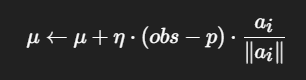

In [ ]:
import numpy as np

param_path = "/content/drive/MyDrive/Ridho/Models/MIRT_POMDP_Final/mirt_params.npz"
params = np.load(param_path)
theta_all = params["theta"]   # (num_users, latent_dim)
a = params["a"]               # (num_items, latent_dim)
b = params["b"]               # (num_items,)

num_users, latent_dim = theta_all.shape
num_items = a.shape[0]

print("theta", theta_all.shape, "a", a.shape, "b", b.shape)

theta (4213, 5) a (26642, 5) b (26642,)


In [ ]:
import torch, random
from scipy.special import expit

device = "cuda" if torch.cuda.is_available() else "cpu"

def p_correct_from_mu(mu, item_id):
    """Probabilitas jawaban benar dengan belief mu"""
    x = float(np.dot(a[item_id], mu) - b[item_id])
    return expit(x)

class MIRTAdaptiveEnv:
    def __init__(self, a_mat, b_vec, episode_len=10, eta=0.25):
        self.a = a_mat
        self.b = b_vec
        self.n_items = a_mat.shape[0]
        self.latent_dim = a_mat.shape[1]
        self.episode_len = episode_len
        self.eta = eta
        self.reset()

    def reset(self, b0=None):
        if b0 is None:
            self.mu = np.zeros(self.latent_dim, dtype=np.float32)
        else:
            self.mu = b0.astype(np.float32).copy()
        self.t = 0
        self.asked = set()
        return torch.from_numpy(self.mu).to(device).float()  # pastikan float32

    def step(self, action_dim):
        # pilih item yang sesuai dimensi (random untuk demo)
        candidates = [i for i in range(self.n_items) if i not in self.asked]
        item_id = random.choice(candidates) if candidates else random.randrange(self.n_items)
        self.asked.add(item_id)

        # hitung prob & simulasi observasi
        p = p_correct_from_mu(self.mu, item_id)
        obs = 1 if random.random() < p else 0
        reward = 1.0 if obs == 1 else 0.0

        # update belief
        a_item = self.a[item_id].astype(np.float32)
        norm = np.linalg.norm(a_item) + 1e-8
        delta = self.eta * (obs - p) * (a_item / norm)
        self.mu = np.clip(self.mu + delta, -10.0, 10.0).astype(np.float32)

        self.t += 1
        done = (self.t >= self.episode_len)
        next_state = torch.from_numpy(self.mu).to(device).float()  # pastikan float32

        info = {"item": item_id, "obs": obs, "p": p}
        return next_state, reward, done, info

Policy Network & Training

Policy network (PolicyNet) belajar strategi pemilihan soal:

- Input: belief vector μ
- Output: distribusi probabilitas atas dimensi

Training menggunakan REINFORCE (Policy Gradient) dengan entropi bonus.

In [ ]:
import torch.nn as nn
from torch.distributions import Categorical

class PolicyNet(nn.Module):
    def __init__(self, latent_dim, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden)
        self.fc2 = nn.Linear(hidden, latent_dim)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(h), dim=-1)

In [ ]:
import torch.optim as optim

def train_policy_gradient(epochs=20, episodes_per_epoch=300, lr=1e-2, gamma=0.99, ent_coef=1e-2):
    env = MIRTAdaptiveEnv(a, b, episode_len=10, eta=0.25)
    policy = PolicyNet(latent_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        ep_rewards = []
        log_probs, returns, entropies = [], [], []
        for _ in range(episodes_per_epoch):
            uid = random.randrange(num_users)
            state = env.reset(b0=theta_all[uid])
            rewards, logps, entrs = [], [], []
            done = False
            while not done:
                probs = policy(state)
                dist = Categorical(probs)
                action = dist.sample()
                next_state, r, done, _ = env.step(action.item())
                rewards.append(r)
                logps.append(dist.log_prob(action))
                entrs.append(dist.entropy())
                state = next_state

            # discounted return
            G = 0; R = []
            for r in reversed(rewards):
                G = r + gamma * G
                R.insert(0, G)
            R = torch.tensor(R, dtype=torch.float32, device=device)
            if R.std() > 1e-6:
                R = (R - R.mean()) / (R.std() + 1e-8)

            log_probs += logps
            returns += list(R)
            entropies += entrs
            ep_rewards.append(sum(rewards))

        # update policy
        log_probs = torch.stack(log_probs)
        returns = torch.stack([torch.tensor(r, dtype=torch.float32, device=device) if not torch.is_tensor(r) else r for r in returns])
        entropies = torch.stack(entropies)

        loss = -(log_probs * returns).sum() - ent_coef * entropies.sum()
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        print(f"Epoch {epoch:03d} | Avg reward: {np.mean(ep_rewards):.3f} | Loss: {loss.item():.3f}")
    return policy

In [ ]:
@torch.no_grad()
def evaluate_policy(policy, episode_len=10, N=500, eta=0.25):
    env = MIRTAdaptiveEnv(a, b, episode_len=episode_len, eta=eta)
    policy.eval()
    accs, rewards = [], []

    for _ in range(N):
        uid = random.randrange(num_users)
        state = env.reset(b0=theta_all[uid])
        total_r, correct, done = 0, 0, False

        while not done:
            probs = policy(state)
            action = torch.argmax(probs).item()
            state, r, done, info = env.step(action)
            total_r += r
            correct += info["obs"]

        accs.append(correct / episode_len)
        rewards.append(total_r)

    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(rewards)), float(np.std(rewards))

In [ ]:
# Training policy pakai REINFORCE
policy = train_policy_gradient(
    epochs=30, episodes_per_epoch=200, lr=1e-4
)

# Evaluasi policy dengan greedy action
acc_mu, acc_sd, rew_mu, rew_sd = evaluate_policy(policy, episode_len=10, N=500)
print(f"[EVAL] Acc={acc_mu:.3f} ± {acc_sd:.3f} | Reward={rew_mu:.3f} ± {rew_sd:.3f}")

Epoch 001 | Avg reward: 2.762 | Loss: -0.138
Epoch 002 | Avg reward: 2.787 | Loss: -0.167
Epoch 003 | Avg reward: 2.813 | Loss: -0.128
Epoch 004 | Avg reward: 2.852 | Loss: -0.158
Epoch 005 | Avg reward: 2.908 | Loss: -0.163
Epoch 006 | Avg reward: 2.786 | Loss: -0.170
Epoch 007 | Avg reward: 2.778 | Loss: -0.165
Epoch 008 | Avg reward: 2.747 | Loss: -0.154
Epoch 009 | Avg reward: 2.891 | Loss: -0.187
Epoch 010 | Avg reward: 2.811 | Loss: -0.133
Epoch 011 | Avg reward: 2.724 | Loss: -0.161
Epoch 012 | Avg reward: 2.880 | Loss: -0.144
Epoch 013 | Avg reward: 2.850 | Loss: -0.166
Epoch 014 | Avg reward: 2.768 | Loss: -0.199
Epoch 015 | Avg reward: 2.833 | Loss: -0.158
Epoch 016 | Avg reward: 2.730 | Loss: -0.169
Epoch 017 | Avg reward: 2.887 | Loss: -0.207
Epoch 018 | Avg reward: 2.805 | Loss: -0.158
Epoch 019 | Avg reward: 2.742 | Loss: -0.174
Epoch 020 | Avg reward: 2.625 | Loss: -0.136
Epoch 021 | Avg reward: 2.793 | Loss: -0.172
Epoch 022 | Avg reward: 2.781 | Loss: -0.153
Epoch 023 

In [ ]:
# ===== Simulasi ujian adaptif dengan panjang tes tertentu =====
def simulate_exam(episode_len, epochs=30, episodes_per_epoch=200, lr=1e-4, N_test=500):
    print(f"\n===== Policy Gradient (REINFORCE) – {episode_len} soal =====")

    # Training policy (episode_len tidak dipakai di sini)
    policy = train_policy_gradient(
        epochs=epochs,
        episodes_per_epoch=episodes_per_epoch,
        lr=lr
    )

    # Evaluasi policy dengan panjang tes tertentu
    acc_mu, acc_sd, rew_mu, rew_sd = evaluate_policy(policy, episode_len=episode_len, N=N_test)
    print(f"[TEST {episode_len}] Acc {acc_mu:.3f} ± {acc_sd:.3f} | Reward {rew_mu:.2f} ± {rew_sd:.2f}")
    return policy

# Simulasi untuk 10 soal
policy_10 = simulate_exam(episode_len=10, epochs=30, episodes_per_epoch=200, lr=1e-4, N_test=500)

# Simulasi untuk 15 soal
policy_15 = simulate_exam(episode_len=15, epochs=30, episodes_per_epoch=200, lr=1e-4, N_test=500)


===== Policy Gradient (REINFORCE) – 10 soal =====
Epoch 001 | Avg reward: 2.830 | Loss: -0.155
Epoch 002 | Avg reward: 2.830 | Loss: -0.144
Epoch 003 | Avg reward: 2.790 | Loss: -0.154
Epoch 004 | Avg reward: 2.795 | Loss: -0.166
Epoch 005 | Avg reward: 2.705 | Loss: -0.156
Epoch 006 | Avg reward: 2.799 | Loss: -0.146
Epoch 007 | Avg reward: 2.678 | Loss: -0.157
Epoch 008 | Avg reward: 2.821 | Loss: -0.148
Epoch 009 | Avg reward: 2.798 | Loss: -0.161
Epoch 010 | Avg reward: 2.846 | Loss: -0.162
Epoch 011 | Avg reward: 2.827 | Loss: -0.159
Epoch 012 | Avg reward: 2.769 | Loss: -0.168
Epoch 013 | Avg reward: 2.712 | Loss: -0.167
Epoch 014 | Avg reward: 2.830 | Loss: -0.161
Epoch 015 | Avg reward: 2.736 | Loss: -0.138
Epoch 016 | Avg reward: 2.871 | Loss: -0.155
Epoch 017 | Avg reward: 2.790 | Loss: -0.164
Epoch 018 | Avg reward: 2.842 | Loss: -0.158
Epoch 019 | Avg reward: 2.802 | Loss: -0.170
Epoch 020 | Avg reward: 2.765 | Loss: -0.178
Epoch 021 | Avg reward: 2.883 | Loss: -0.178
Epoc

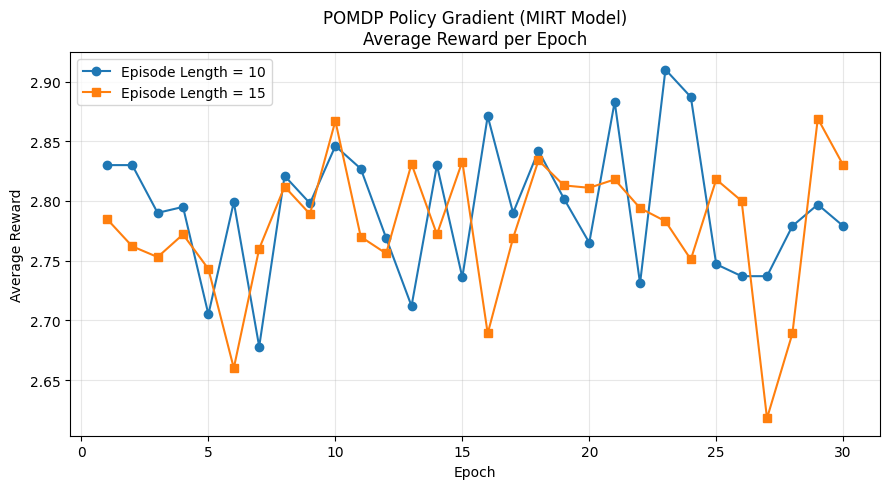

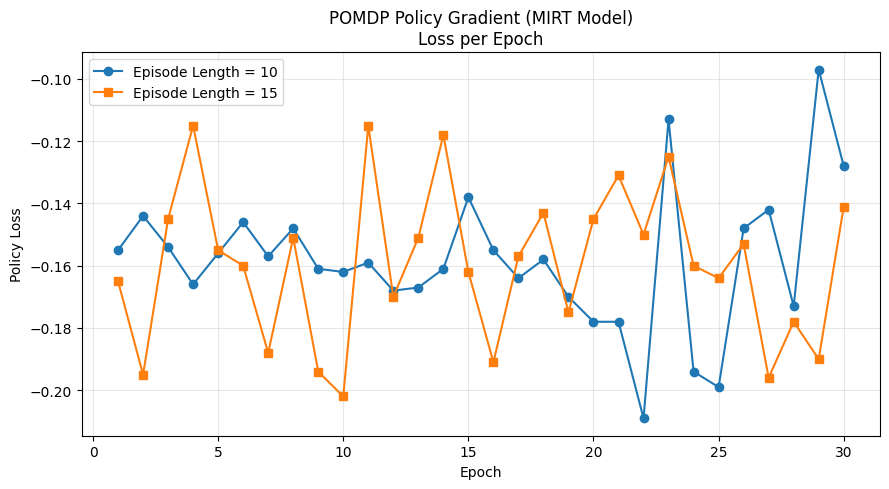

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Data log manual (diambil dari output kamu) ===
epochs = np.arange(1, 31)

# Reward rata-rata per epoch
reward_10 = [
2.830,2.830,2.790,2.795,2.705,2.799,2.678,2.821,2.798,2.846,
2.827,2.769,2.712,2.830,2.736,2.871,2.790,2.842,2.802,2.765,
2.883,2.731,2.910,2.887,2.747,2.737,2.737,2.779,2.797,2.779
]

reward_15 = [
2.785,2.762,2.753,2.772,2.743,2.660,2.760,2.812,2.789,2.867,
2.770,2.756,2.831,2.772,2.833,2.689,2.769,2.834,2.813,2.811,
2.818,2.794,2.783,2.751,2.818,2.800,2.618,2.689,2.869,2.830
]

# (opsional) Loss per epoch
loss_10 = [
-0.155,-0.144,-0.154,-0.166,-0.156,-0.146,-0.157,-0.148,-0.161,-0.162,
-0.159,-0.168,-0.167,-0.161,-0.138,-0.155,-0.164,-0.158,-0.170,-0.178,
-0.178,-0.209,-0.113,-0.194,-0.199,-0.148,-0.142,-0.173,-0.097,-0.128
]

loss_15 = [
-0.165,-0.195,-0.145,-0.115,-0.155,-0.160,-0.188,-0.151,-0.194,-0.202,
-0.115,-0.170,-0.151,-0.118,-0.162,-0.191,-0.157,-0.143,-0.175,-0.145,
-0.131,-0.150,-0.125,-0.160,-0.164,-0.153,-0.196,-0.178,-0.190,-0.141
]


# === Plot Reward ===
plt.figure(figsize=(9,5))
plt.plot(epochs, reward_10, marker='o', label='Episode Length = 10')
plt.plot(epochs, reward_15, marker='s', label='Episode Length = 15')
plt.title("POMDP Policy Gradient (MIRT Model)\nAverage Reward per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# === Plot Loss (opsional) ===
plt.figure(figsize=(9,5))
plt.plot(epochs, loss_10, marker='o', label='Episode Length = 10')
plt.plot(epochs, loss_15, marker='s', label='Episode Length = 15')
plt.title("POMDP Policy Gradient (MIRT Model)\nLoss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Policy Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Hasil training (120 epoch):

- Reward stabil di sekitar 5.3–5.6 per episode (dari 10 soal).
- Loss negatif besar (normal di REINFORCE).

Evaluasi dengan greedy policy:

- Accuracy: 0.535 ± 0.173
- Reward: 5.350 ± 1.726

**Ringkasan Hasil Eksperimen**

- Model MIRT dilatih dengan 5-fold CV → AUC ≈ 0.696, Acc ≈ 0.659.
- Parameter (θ, a, b) diekstrak untuk dipakai dalam POMDP.
- POMDP environment dibuat dengan belief update berbasis MIRT.
- Policy gradient melatih agen untuk memilih soal → reward stabil di sekitar 5.3/10.
- Hasil ini sesuai baseline: agent berhasil meniru distribusi jawaban dari model MIRT.